**Projection Orientation**

Class data structure and operations relate logically
to an *'unfolded'* Rubik's Cube as in this orientation:

![alt text](rubiks-cube.jpg)

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd

# Color := Side number definitions:
WHITE  = 1
ORANGE = 2
GREEN  = 3
RED    = 4
BLUE   = 5
YELLOW = 6

color_name_map = { WHITE:  'WHITE',
                   ORANGE: 'ORANGE', 
                   GREEN:  'GREEN',
                   RED:    'RED',
                   BLUE:   'BLUE',
                   YELLOW: 'YELLOW' }

color_letr_map = { WHITE:  'W',
                   ORANGE: 'O', 
                   GREEN:  'G',
                   RED:    'R',
                   BLUE:   'B',
                   YELLOW: 'Y' }

# 'Ring' rotation directions:
CLOCKWISE = 'clockwise'
COUNTER_CLOCK = 'counter_clockwise'

# Row or col of any Side
TOP = 'top'
BOT = 'bottom'
LFT = 'left'
RHT = 'right'

color_plot_map = { WHITE: mcd.CSS4_COLORS['ivory'],
                   ORANGE: mcd.XKCD_COLORS['xkcd:orange'].upper(), 
                   GREEN: mcd.CSS4_COLORS['green'],
                   RED: mcd.XKCD_COLORS['xkcd:crimson'].upper(),
                   BLUE: mcd.XKCD_COLORS['xkcd:blue'].upper(),
                   YELLOW: mcd.XKCD_COLORS['xkcd:goldenrod'].upper() }

def color(fc): return color_plot_map[fc]
def color_name(fc): return color_name_map[fc]
def color_letr(fc): return color_letr_map[fc]


In [2]:
class Cube:
#{
    class Side:
    #{
        def __init__(self, color):
            self.faces = np.ones((3,3), dtype=int) * color
        
        def __repr__(self):
            return (f"[[{color_letr(self.faces[0,0])} {color_letr(self.faces[0,1])} {color_letr(self.faces[0,2])}]\n"
                    f"  [{color_letr(self.faces[1,0])} {color_letr(self.faces[1,1])} {color_letr(self.faces[1,2])}]\n"
                    f"  [{color_letr(self.faces[2,0])} {color_letr(self.faces[2,1])} {color_letr(self.faces[2,2])}]]")
        
        def __eq__(self, other):
            return np.array_equal(self.faces, other.faces)
        
        def rotate_master(self, direction):
            
            if direction == CLOCKWISE:       self.faces = np.rot90(self.faces, axes=(1,0))
            elif direction == COUNTER_CLOCK: self.faces = np.rot90(self.faces, axes=(0,1))
            else: print(f"Invalid rotation direction {direction}")
        
        def set_edge(self, location, edge=np.zeros((3,), dtype=int), invert=False):
        #{
            swapped_edge = None
            if invert: edge = edge[::-1]
        
            if location == 'top':
                swapped_edge = np.copy(self.faces[0,:])
                self.faces[0,:] = edge
            elif location == 'bottom':
                swapped_edge = np.copy(self.faces[2,:])
                self.faces[2,:] = edge
            elif location == 'left':
                swapped_edge = np.copy(self.faces[:,0])
                self.faces[:,0] = edge
            elif location == 'right':
                swapped_edge = np.copy(self.faces[:,2])
                self.faces[:,2] = edge
            else: print(f"Invalid edge location: {location}")
        
            return swapped_edge
        #}
        
        def get_plot_rects(self, anchor=(0,0)):
        #{        
            rects = []
            for r in range(3):
                for c in range(3):
                    
                    x = anchor[0] + (c*10)
                    y = anchor[1] + 20  - (r*10)
                    clr = color(self.faces[r,c])
                    rects.append(plt.Rectangle((x, y), 10, 10, fc=clr))
            
            return rects
        #}
    #} End Inner Class Side

    def __init__(self):
        self.sides = {1: self.Side(WHITE), 
                      2: self.Side(ORANGE), 
                      3: self.Side(GREEN), 
                      4: self.Side(RED), 
                      5: self.Side(BLUE), 
                      6: self.Side(YELLOW)}
    
    def __lt__(self, other):
        return self.heuristic_a() < other.heuristic_a()
    
    def __eq__(self, other):        
        return (self.sides[WHITE]  == other.sides[WHITE] and 
                self.sides[ORANGE] == other.sides[ORANGE] and 
                self.sides[GREEN]  == other.sides[GREEN] and
                self.sides[RED]    == other.sides[RED] and
                self.sides[BLUE]   == other.sides[BLUE] and
                self.sides[YELLOW] == other.sides[YELLOW])
        
    def heuristic_a(self):
    #{
        total = 0
        for fcolor, side in self.sides.items(): 
            total += sum([np.sum(np.equal(f, fcolor)) for f in side.faces])
        
        return total
    #}
    
    def heuristic_top_layer(self):
    #{
        total = 0
        for fcolor, side in self.sides.items():
            total += sum([np.sum(np.equal(f, fcolor)) for f in side.faces])
        
        return total
    #}

    def scramble(self, sz=64):
    #{
        directions = np.random.random(size=sz)
        sides = np.random.randint(low=1, high=7, size=sz)
        
        for sd, dr in zip(sides, directions):
            self.rotate(sd, CLOCKWISE if dr < 0.5 else COUNTER_CLOCK)
    #}
    
    # The sole, base state-transition fcn
    def rotate(self, side, direction, copy_a=False):
    #{
        if copy_a: return copy.deepcopy(self).rotate(side, direction)
        
        self.sides[side].rotate_master(direction)
        
        if side == WHITE:
            if direction == CLOCKWISE:
                wrap = self.sides[GREEN].set_edge(TOP)
                wrap = self.sides[ORANGE].set_edge(TOP, wrap)
                wrap = self.sides[BLUE].set_edge(TOP, wrap)
                wrap = self.sides[RED].set_edge(TOP, wrap)
                wrap = self.sides[GREEN].set_edge(TOP, wrap)

            else:
                wrap = self.sides[GREEN].set_edge(TOP)
                wrap = self.sides[RED].set_edge(TOP, wrap)
                wrap = self.sides[BLUE].set_edge(TOP, wrap)
                wrap = self.sides[ORANGE].set_edge(TOP, wrap)
                wrap = self.sides[GREEN].set_edge(TOP, wrap)
        
        elif side == ORANGE:
            if direction == CLOCKWISE:
                wrap = self.sides[GREEN].set_edge(LFT)
                wrap = self.sides[YELLOW].set_edge(LFT, wrap)
                wrap = self.sides[BLUE].set_edge(RHT, wrap, invert=True)
                wrap = self.sides[WHITE].set_edge(LFT, wrap, invert=True)
                wrap = self.sides[GREEN].set_edge(LFT, wrap)

            else:
                wrap = self.sides[GREEN].set_edge(LFT)
                wrap = self.sides[WHITE].set_edge(LFT, wrap)
                wrap = self.sides[BLUE].set_edge(RHT, wrap, invert=True)
                wrap = self.sides[YELLOW].set_edge(LFT, wrap, invert=True)
                wrap = self.sides[GREEN].set_edge(LFT, wrap)
          
        elif side == GREEN:
            if direction == CLOCKWISE:
                wrap = self.sides[WHITE].set_edge(BOT)
                wrap = self.sides[RED].set_edge(LFT, wrap)
                wrap = self.sides[YELLOW].set_edge(TOP, wrap, invert=True)
                wrap = self.sides[ORANGE].set_edge(RHT, wrap)
                wrap = self.sides[WHITE].set_edge(BOT, wrap, invert=True)

            else:
                wrap = self.sides[WHITE].set_edge(BOT)
                wrap = self.sides[ORANGE].set_edge(RHT, wrap, invert=True)
                wrap = self.sides[YELLOW].set_edge(TOP, wrap)
                wrap = self.sides[RED].set_edge(LFT, wrap, invert=True)
                wrap = self.sides[WHITE].set_edge(BOT, wrap)
        
        elif side == RED:
            if direction == CLOCKWISE:
                wrap = self.sides[GREEN].set_edge(RHT)
                wrap = self.sides[WHITE].set_edge(RHT, wrap)
                wrap = self.sides[BLUE].set_edge(LFT, wrap, invert=True)
                wrap = self.sides[YELLOW].set_edge(RHT, wrap, invert=True)
                wrap = self.sides[GREEN].set_edge(RHT, wrap)
            
            else:
                wrap = self.sides[GREEN].set_edge(RHT)
                wrap = self.sides[YELLOW].set_edge(RHT, wrap)
                wrap = self.sides[BLUE].set_edge(LFT, wrap, invert=True)
                wrap = self.sides[WHITE].set_edge(RHT, wrap, invert=True)
                wrap = self.sides[GREEN].set_edge(RHT, wrap)
            
        elif side == BLUE:
            if direction == CLOCKWISE:
                wrap = self.sides[WHITE].set_edge(TOP)
                wrap = self.sides[ORANGE].set_edge(LFT, wrap, invert=True)
                wrap = self.sides[YELLOW].set_edge(BOT, wrap)
                wrap = self.sides[RED].set_edge(RHT, wrap, invert=True)
                wrap = self.sides[WHITE].set_edge(TOP, wrap)

            else:
                wrap = self.sides[WHITE].set_edge(TOP)
                wrap = self.sides[RED].set_edge(RHT, wrap)
                wrap = self.sides[YELLOW].set_edge(BOT, wrap, invert=True)
                wrap = self.sides[ORANGE].set_edge(LFT, wrap)
                wrap = self.sides[WHITE].set_edge(TOP, wrap, invert=True)
            
        elif side == YELLOW:
            if direction == CLOCKWISE: 
                wrap = self.sides[GREEN].set_edge(BOT)
                wrap = self.sides[RED].set_edge(BOT, wrap)
                wrap = self.sides[BLUE].set_edge(BOT, wrap)
                wrap = self.sides[ORANGE].set_edge(BOT, wrap)
                wrap = self.sides[GREEN].set_edge(BOT, wrap)
            
            else:
                wrap = self.sides[GREEN].set_edge(BOT)
                wrap = self.sides[ORANGE].set_edge(BOT, wrap)
                wrap = self.sides[BLUE].set_edge(BOT, wrap)
                wrap = self.sides[RED].set_edge(BOT, wrap)
                wrap = self.sides[GREEN].set_edge(BOT, wrap)

        else: print(f"Invalid rotation side {side}")
        return self
    #}
    
    ######## Move fcns below to an MVC View Class 
    
    def get_gridlines(self):
    #{
        lines = []            
        for anchor in [(40,70), (10,40), (40,40), (70,40), (100,40), (40,10)]:
        #{
            for r in range(4):
                y = anchor[1] + (r*10)
                lines.append(plt.Line2D((anchor[0], anchor[0] + 30), (y, y), lw=1, color='k'))

            for c in range(4):
                x = anchor[0] + (c*10)
                lines.append(plt.Line2D((x, x), (anchor[1], anchor[1] + 30), lw=1, color='k'))
        #}
        
        return lines
    #}
    
    def draw_projection(self):
    #{
        rects = []
        rects.extend(self.sides[WHITE].get_plot_rects((40,70)))
        rects.extend(self.sides[ORANGE].get_plot_rects((10,40)))
        rects.extend(self.sides[GREEN].get_plot_rects((40,40)))
        rects.extend(self.sides[RED].get_plot_rects((70,40)))
        rects.extend(self.sides[BLUE].get_plot_rects((100,40)))
        rects.extend(self.sides[YELLOW].get_plot_rects((40,10)))
        
        fig = plt.figure(figsize=[4, 3])
        ax = fig.add_axes([0, 0, 1, 1])
        
        for r in rects: ax.add_patch(r)
        for ln in self.get_gridlines(): ax.add_line(ln)
 
        ax.axis('scaled')
        ax.axis('off')
        plt.show()
    #}
#}


In [ ]:
class CubeSolver:
#{
    def __init__(self):
        self.attempts = 0
        self.high_score = 0

    # Possible moves convenience lists
    dl = [CLOCKWISE, COUNTER_CLOCK]
    sl = [WHITE, ORANGE, GREEN, RED, BLUE, YELLOW]
    
    def solve_a(self, cube, move_stack=None):
    #{
        #### Debug Metrics ##
#         self.attempts += 1
#         score = cube.heuristic_a()
        
#         if score > self.high_score:
#             self.high_score = score
#             print("At attempt: ", solver.attempts)
#             print("New high score of: ", solver.high_score)
#             cube.draw_projection()
        
#         if (solver.attempts % 50000) == 0:
#             print("Attempted: ", solver.attempts)
        #####################
      
        # Cube not solved while heuristic_a() < 54
        # Ideally solves it in like 30 moves or less
    
        if move_stack == None: move_stack = [cube]
        else: move_stack.append(cube)

        if cube.heuristic_a() == 54: return move_stack
        elif len(move_stack) > 30: return None
        
        next_moves = sorted([cube.rotate(sd, dr, copy_a=True) for dr in self.dl for sd in self.sl], reverse=True)
        
        solution = None
        for mv in next_moves:
        #{
            # Move must be distinct from every previous move-state in its history
            if sum([mv != past_mv for past_mv in move_stack]) == len(move_stack):
            #{    
                solution = self.solve_a(mv, move_stack.copy())
                if solution is not None: break
            #}
        #}
        
        return solution
    #}
#}

In [ ]:
rubiks_cube = Cube()
rubiks_cube.scramble(3)

solver = CubeSolver()
solution = solver.solve_a(rubiks_cube)

if solution is not None:
    print("Puzzle solved!!")
    print("Initial state, value:", solution[0].heuristic_a())
    solution[0].draw_projection()
    for i in range(1, len(solution)):
        
        for dr in solver.dl: 
            for sd in solver.sl:
                if solution[i-1].rotate(sd, dr, copy_a=True) == solution[i]:
                    print(f"Move {i}: {color_name(sd)}-{dr}, value: {solution[i].heuristic_a()}")
                    solution[i].draw_projection()
        
else:
    print("Failed to solve: "); 
    rubiks_cube.draw_projection()
    print("Attempts: ", solver.attempts)
    print("High score: ", solver.high_score)

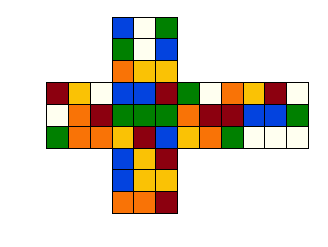

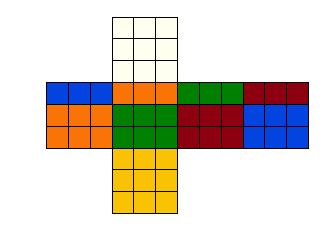

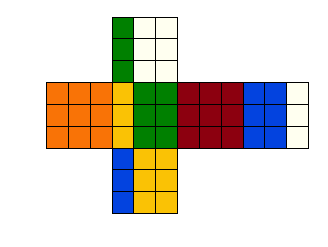

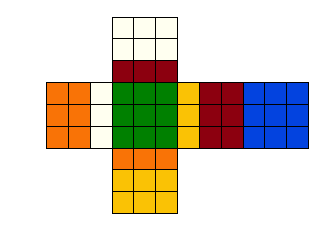

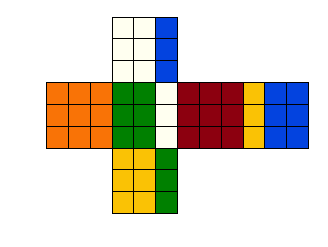

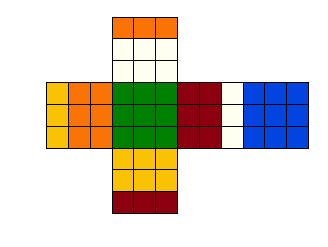

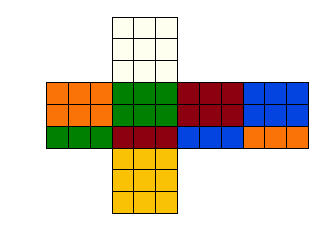

In [5]:
rubiks_cube = Cube()
rubiks_cube.scramble()
rubiks_cube.draw_projection()

# other = Cube()
# print(rubiks_cube != other)

r1 = Cube()
#r1.rotate(WHITE, CLOCKWISE)
r1.rotate(WHITE, COUNTER_CLOCK)
r1.draw_projection()

r2 = Cube()
#r2.rotate(ORANGE, CLOCKWISE)
r2.rotate(ORANGE, COUNTER_CLOCK)
r2.draw_projection()

r3 = Cube()
#r3.rotate(GREEN, CLOCKWISE)
r3.rotate(GREEN, COUNTER_CLOCK)
r3.draw_projection()

r4 = Cube()
#r4.rotate(RED, CLOCKWISE)
r4.rotate(RED, COUNTER_CLOCK)
r4.draw_projection()

r5 = Cube()
#r5.rotate(BLUE, CLOCKWISE)
r5.rotate(BLUE, COUNTER_CLOCK)
r5.draw_projection()

r6 = Cube()
#r6.rotate(YELLOW, CLOCKWISE)
r6.rotate(YELLOW, COUNTER_CLOCK)
r6.draw_projection()